In [1]:
import numpy as np
import xarray as xr
from itertools import product
import xsimlab as xs
from xsimlab import variable as var, global_ref as glob
import pandas as pd
import zarr
import matplotlib.pyplot as plt
import networkx as nx

# 20210805_sandbox

Try adding a `risk` axis and continue to have `foi` and `foi_bf` methods consistent.

# Utils

In [2]:
def get_var_dims(process, name) -> tuple:
    """Given process-wrapped class `process`, retrieve the `dims` metadata
    attribute for variable with `name`.
    """
    if not '__xsimlab_cls__' in dir(process):
        raise TypeError(
            f"Expected type 'xsimlab.Process' for arg `process`, received " +
            f"'{type(process)}'"
        )
    var = xs.utils.variables_dict(process).get(name, None)
    if var is None:
        raise AttributeError(f"process '{process}' has no attribute '{name}'")
    return tuple(var.metadata['dims'][0])


In [3]:
def group_dict_by_var(d: dict) -> dict:
    return {k: d[(proc, k)] for (proc, k) in d}

# Define Processes

In [4]:
@xs.process
class RecoveryRate:
    """Provide a `rate_I2R`"""
    rate_I2R = var(global_name='rate_I2R', groups=['tm'], intent='out')
    gamma = var(global_name='gamma', intent='in')
    state = glob('state', intent='in')

    def run_step(self):
        self.rate_I2R = self.gamma * self.I
    
    @property
    def I(self):
        return self.state.loc[dict(compt='I')]

In [5]:
@xs.process
class InitComptGraph:
    """Generate a toy compartment graph"""
    compt_graph = glob('compt_graph', intent='out')

    def get_compt_graph(self) -> nx.DiGraph:
        g = nx.DiGraph()
        g.add_nodes_from([
            ('S', {"color": "red"}),
            ('I', {"color": "blue"}),
            ('R', {"color": "green"}),
        ])
        g.add_edges_from([
            ('S', 'I', {"priority": 0, "color": "red"}),
            ('I', 'R', {"priority": 1, "color": "blue"}),
        ])
        return g
    
    def vis(self):
        return nx.draw(self.compt_graph)
    
    def initialize(self):
        self.compt_graph = self.get_compt_graph()

In [6]:
@xs.process
class SEIR:
    """Sums subsets of TM (in group `tm`) from many processes to output TM."""
    STATE_DIMS = ('vertex', 'compt', 'age', 'risk')
    _tm_subset = xs.group_dict('tm')
    state = var(dims=STATE_DIMS, intent='inout', global_name='state')
    tm = var(dims=STATE_DIMS, intent='out', global_name='tm')
    compt_graph = var('compt_graph', intent='in', global_name='compt_graph')
    
    def run_step(self):
        """In particular, we need to ensure that `tm_subset` and `tm` refresh
        at every timestep.
        """
        self.tm = self.init_tm()
        self.tm_subset = self.get_tm_subset()
        self.apply_edges()

    def finalize_step(self):
        self.state += self.tm
        
    def init_tm(self):
        """Initialize transition matrix (TM) as a matrix of zeros."""
        return xr.zeros_like(self.state)
        
    def apply_edges(self):
        """Iterate over edges in `compt_graph` in ascending order of `priority`.
        Apply each edge to the TM.
        """
        # TODO: represent as tuples by prioirity
        for (u, v) in self.compt_graph.edges:
            self.edge_to_tm(u, v)
    
    def edge_to_tm(self, u, v) -> None:
        """Applies to the transition matrix (TM) the weight of a directed edge 
        from compartment `u` to compartment `v`. Find the element-wise
        minimum of origin node state and weight of outgoing edge to ensure
        that origin node state is always non-negative after edge weight has
        been applied.
        """
        weight = xr.ufuncs.minimum(
            # origin node weight
            self.state.loc[dict(compt=u)],
            # unadjusted edge weight
            self.edge_weight(u, v)
        )
        # print(f"adjusted weight of edge from {u} to {v} is {weight}")
        self.tm.loc[dict(compt=u)] -= weight
        self.tm.loc[dict(compt=v)] += weight
        
    def edge_weight(self, u, v):
        """Try to find an edge weight for (u, v) from `tm_subset`."""
        key = self.edge_weight_name(u, v)
        if key not in self.tm_subset:
            print(f"WARNING: could not find a weight for transition from {u} to {v} compartment ({key})")
            weight = 0.
        else:
            weight = self.tm_subset[key]
        return weight
    
    def edge_weight_name(self, u, v) -> str:
        """Key to look for when finding edge weights between nodes `u` and `v`."""
        return f"rate_{u}2{v}"
    
    def get_tm_subset(self):
        """`_tm_subset` indexes on (`process_name`, `variable_name`), so we must convert
        keys to `variable_name`.
        """
        return group_dict_by_var(self._tm_subset)

In [29]:
@xs.process
class InitCoords:
    """Initialize state coordinates"""
    compt = var(global_name='compt_coords', groups=['state_coords'], intent='out')
    age = var(global_name='age_coords', groups=['state_coords'], intent='out')
    risk = var(global_name='risk_coords', groups=['state_coords'], intent='out')
    vertex = var(global_name='vertex_coords', groups=['state_coords'], intent='out')
    
    def initialize(self):
        self.compt = ['S', 'I', 'R'] 
        self.age = ['0-4', '5-17', '18-49', '50-64', '65+']
        self.risk = ['low', 'high']
        self.vertex = ['Austin', 'Houston', 'San Marcos', 'Dallas']

In [30]:
@xs.process
class InitState:
    """Initialize state matrix"""
    _state_coords = xs.group_dict('state_coords')
    state = glob('state', intent='out')
    
    def initialize(self):
        self.state = xr.DataArray(
            data=0.,
            dims=self.state_dims,
            coords=self.state_coords
        )
        self.state.loc[dict(compt='S')] = np.array([[1000, 900, 800, 700, 600]] * 2).T
        self.state.loc[dict(compt='I')] = np.array([[100, 90, 80, 70, 60]] * 2).T
    
    @property
    def state_dims(self):
        return get_var_dims(SEIR, 'state')
    
    @property
    def state_coords(self):
        return group_dict_by_var(self._state_coords)

In [31]:
@xs.process
class InitPhi:
    """Set value of phi (contacts per unit time)."""
    PHI_DIMS = ('age0', 'age1', 'risk0', 'risk1', 'vertex0', 'vertex1', )
    RANDOM_PHI_DATA = np.array([
        [0.89, 0.48, 0.31, 0.75, 0.07],
        [0.64, 0.69, 0.13, 0.00, 0.05],
        [0.46, 0.58, 0.19, 0.16, 0.11],
        [0.53, 0.36, 0.26, 0.35, 0.13],
        [0.68, 0.70, 0.36, 0.23, 0.28]
    ]) 
    phi = glob('phi', intent='out')
    vertex_coords = glob('vertex_coords', intent='in')
    age_coords = glob('age_coords', intent='in')
    risk_coords = glob('risk_coords', intent='in')
    
    def initialize(self):
        data = self.extend_phi_dims(self.RANDOM_PHI_DATA, self.risk_coords)
        data = self.extend_phi_dims(data, self.vertex_coords)
        self.phi = xr.DataArray(data=data, dims=self.phi_dims, coords=self.phi_coords)
    
    def extend_phi_dims(self, data, coords) -> np.ndarray:
        f = lambda data, coords: np.stack([data] * len(coords), axis=-1)
        return f(f(data, coords), coords)
    
    @property
    def phi_dims(self):
        return self.PHI_DIMS
    
    @property
    def phi_coords(self):
        return dict(age0=self.age_coords, age1=self.age_coords, risk0=self.risk_coords, risk1=self.risk_coords, vertex0=self.vertex_coords, vertex1=self.vertex_coords,)

In [32]:
def reindex_to_phi(da: xr.DataArray, suffix: str = '0') -> xr.DataArray:
    pass

def reindex_from_phi(da: xr.DataArray) -> xr.DataArray:
    """
    TODO: matches an arg regex
    """
    pass

In [42]:
@xs.process
class FOI:
    """Calculate force of infection (FOI) with naive
    for looping.
    """
    PHI_DIMS = ('age0', 'age1', 'risk0', 'risk1', 'vertex0', 'vertex1',)
    FOI_DIMS = ('age', 'risk', 'vertex', )
    state = glob('state', intent='in')
    beta = var(global_name='beta', intent='in')
    phi = var(dims=PHI_DIMS, global_name='phi', intent='in')
    rate_S2I = var(intent='out', groups=['tm'])
    vertex_coords = glob('vertex_coords', intent='in')
    age_coords = glob('age_coords', intent='in')
    risk_coords = glob('risk_coords', intent='in')
    
    def run_step(self):
        self.rate_S2I = self.foi
        # print("foi_bf: ", self.foi_bf)
        # print("foi: ", self.foi)
        # assert 0
    
    def init_foi(self) -> xr.DataArray:
        return xr.DataArray(data=0., dims=self.FOI_DIMS, coords=dict(age=self.age_coords, risk=self.risk_coords, vertex=self.vertex_coords))
    
    @property
    def foi(self) -> xr.DataArray:
        zero_suffix = self.suffixed_dims(self.S, '0')
        one_suffix = self.suffixed_dims(self.S, '1')
        # S = self.S.rename({'age': 'age0', 'risk': 'risk0'})
        S = self.S.rename(zero_suffix)
        # I = self.I.rename({'age': 'age1', 'risk': 'risk1'})
        I = self.I.rename(one_suffix)
        # N = self.state.sum('compt').rename({'age': 'age1', 'risk': 'risk1'})
        N = self.state.sum('compt').rename(one_suffix)
        foi = ((self.beta * self.phi * S * I / N)
               # sum over coords that are not compt
               .sum(one_suffix.values())
               # like .rename({'age0': 'age', 'risk0': 'risk'})
               .rename({v: k for k, v in zero_suffix.items()}))
        return foi
    
    @property
    def foi_bf(self) -> xr.DataArray:
        """Brute force FOI, like BruteForceFOI in Episimlab v1.0"""
        foi = self.init_foi()
        for a0, r0, v0, a1, r1, v1 in product(*[self.age_coords, self.risk_coords, self.vertex_coords, ] * 2):
            i0, i1 = dict(vertex=v0, age=a0, risk=r0), dict(vertex=v1, age=a1, risk=r1)
            phi = self.phi.loc[dict(age0=a0, age1=a1, risk0=r0, risk1=r1, vertex0=v0, vertex1=v1)].values
            S = self.S.loc[i0].values
            I = self.I.loc[i1].values
            N = self.state.loc[i1].sum('compt').values
            foi.loc[i0] += phi * self.beta * S * I / N
        return foi
    
    @property
    def foi_scalar(self):
        """Only works if phi is a scalar."""
        return self.phi * self.beta * self.S * self.I / self.N
    
    def suffixed_dims(self, da: xr.DataArray, suffix: str = '0', exclude: list = None) -> xr.DataArray:
        if exclude is None:
            exclude = list()
        return {k: f"{k}{suffix}" for k in da.dims if k not in exclude}
    
    def unsuffixed_dims(self, da: xr.DataArray, exclude: list = None) -> xr.DataArray:
        if exclude is None:
            exclude = list()
        f = lambda x: x.rstrip('0123456789')
        return {k: f(k) for k in da.dims if f(k) not in exclude}
    
    @property
    def S(self):
        return self.state.loc[dict(compt='S')]
        
    @property
    def I(self):
        return self.state.loc[dict(compt='I')]
    
    @property
    def N(self):
        return self.state.sum()

# Run Model

In [43]:
model = xs.Model({
    'init_phi': InitPhi,
    'init_coords': InitCoords,
    'init_state': InitState,
    'seir': SEIR,
    'foi': FOI,
    'init_compt_graph': InitComptGraph,
    'recovery_rate': RecoveryRate
})
# model.visualize(show_inputs=True, show_variables=True)

In [48]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'step': pd.date_range(start='3/1/2020', end='3/15/2020', freq='24H')
    },
    input_vars={
        'foi__beta': 0.07,
        'recovery_rate__gamma': 0.5,
    },
    output_vars={
        'seir__state': 'step'
    }
)
out_ds = in_ds.xsimlab.run(model=model, decoding=dict(mask_and_scale=False))

In [49]:
out_ds

<xarray.Dataset>
Dimensions:               (step: 15, vertex: 4, compt: 3, age: 5, risk: 2)
Coordinates:
  * step                  (step) datetime64[ns] 2020-03-01 ... 2020-03-15
Dimensions without coordinates: vertex, compt, age, risk
Data variables:
    foi__beta             float64 0.07
    recovery_rate__gamma  float64 0.5
    seir__state           (step, vertex, compt, age, risk) float64 1e+03 ... ...

## Plot Results

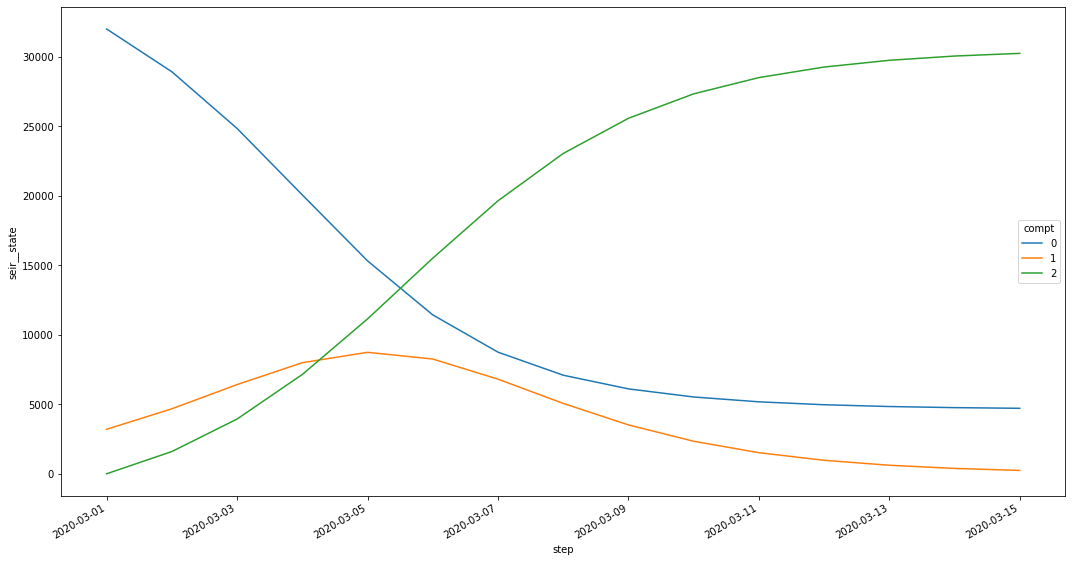

In [50]:
out_ds['seir__state'].sum(['age', 'risk', 'vertex']).plot.line(x='step', aspect=2, size=9)